# Thomas fire

Author: Patricia Park

Repository: https://github.com/p-park6/aqi-false-color.git

## Highlights in this notebook:
- Data tidying and filtering with `pandas`
- Data statistical analysis
- Geospacial data tidying with `geopandas`
- Visualizing data through the forms of a graph and map

## About the Data
Three types of datasets were uses:
1. The first dataset covers the [Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) found on the [US Environmental Protection Agency](https://www.epa.gov) website. Here, we will use the data provided to be able to visualize the air quality over months, and if there were any abnormal spikes that appeared during the [Thomas Fire](https://keyt.com/news/local-news/top-stories/2022/12/04/thomas-fire-5th-year-anniversary/) in 2017.

2. The second dataset includes a collection of bands (including red, green, blue, near-infrared and shortwave infrared). This data is from the [Landsat Collection 2 Surface Reflectance](https://www.usgs.gov/landsat-missions/landsat-collection-2-surface-reflectance), collected by the Landsat 8 satellite. The data was accessed and pre-processed in the Microsoft Planetary Computer to remove data outside land and coarsen the spatial resolution ([Landsat Collection in MPC](https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2)). Data should be used for visualization purposes only.
- Additional information:
    -[Landsat Satellite homepage](https://www.usgs.gov/landsat-missions)


3. The third dataset include the shapefile of the fire perimeters in California during 2017. The [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about).

## Final outputs:
This notebook will output a graph of the AQI over a number of months in Santa Barbara as well as a map showing the area of where the Thomas fire took place.

![](images/aqi_in_santa_barbara.png)

![](images/thomas_fire_perimeter_2017.png)

## Import libraries

In [1]:
import os
import numpy as np
import pandas as pd

import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import matplotlib.patches as mpatches
from matplotlib.markers import MarkerStyle

from shapely import Point
from shapely import Polygon
from shapely import box
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

### Read in necessary data

We'll go ahead and read in all the necessary data we need for the notebook.

In [2]:
# read in daily AQI 2017 zip file from url
aqi_17 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip")

# read in daily AQI 2018 zip file from url
aqi_18 = pd.read_csv("https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip")

# Read in bands dataset
#create pathway
ca_bands_fp = os.path.join(os.getcwd(),'data','landsat8-2018-01-26-sb-simplified.nc')
#read data using pathway
ca_fires_bands_2017 = rioxr.open_rasterio(ca_bands_fp)

# Read in California perimeter dataset
ca_fires_perimeter_2017= gpd.read_file(os.path.join(os.getcwd(),'data', 'California_Fire_Perimeters_2017', 'California_Fire_Perimeters_2017.shp'))

## AQI data

### Prepare AQI data

### Data Exploration:

Let's go ahead and see what is in these datasets

In [3]:
#look at the first 5 observations of aqi 17
aqi_17.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1


In [4]:
#look at the first 5 observations of aqi 18
aqi_18.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2018-01-02,32,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2018-01-05,34,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2018-01-08,15,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2018-01-11,19,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2018-01-14,25,Good,PM2.5,01-003-0010,1


### Merge datasets together

To make data easier to access, we will merge the two datasets together

In [5]:
#join the two datasets together
aqi = pd.concat([aqi_17, aqi_18])
#print to see if the two were joined together sucessfully
aqi.head()

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
0,Alabama,Baldwin,1,3,2017-01-01,21,Good,PM2.5,01-003-0010,1
1,Alabama,Baldwin,1,3,2017-01-04,22,Good,PM2.5,01-003-0010,1
2,Alabama,Baldwin,1,3,2017-01-10,19,Good,PM2.5,01-003-0010,1
3,Alabama,Baldwin,1,3,2017-01-13,30,Good,PM2.5,01-003-0010,1
4,Alabama,Baldwin,1,3,2017-01-16,16,Good,PM2.5,01-003-0010,1
...,...,...,...,...,...,...,...,...,...,...
327532,Wyoming,Weston,56,45,2018-12-27,36,Good,Ozone,56-045-0003,1
327533,Wyoming,Weston,56,45,2018-12-28,35,Good,Ozone,56-045-0003,1
327534,Wyoming,Weston,56,45,2018-12-29,35,Good,Ozone,56-045-0003,1
327535,Wyoming,Weston,56,45,2018-12-30,31,Good,Ozone,56-045-0003,1


### Reformat columns

For easier access, we will rename and reformat the column names

In [20]:
# change column names to lowercase and replace spaces with '_'
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')
#print columns to see if they have been properly replaced
aqi.columns

Index(['state_name', 'county_name', 'state_code', 'county_code', 'date', 'aqi',
       'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')

### Filter data

Now, we will filter our data for the appropriate columns we want to focus on. In this case, we want to look at data from Santa Barbara county and appropriate columns.

In [7]:
#filter for observations that are in Santa Barbara County
aqi_sb = aqi[aqi['county_name'] == 'Santa Barbara']

#remove not needed columns from the data frame
aqi_sb = aqi_sb.drop(columns=['state_name','county_name','state_code','county_code'])

#use column function on aqi_sb dataframe to see if columns were removed
print(aqi_sb.columns)

Index(['date', 'aqi', 'category', 'defining_parameter', 'defining_site',
       'number_of_sites_reporting'],
      dtype='object')


### Change datetime and index

In order for the graph to show the dates in a correct format, we will change the date column to the datetime format. We will also update the index to be the date column

In [8]:
# change date type to be in datetime object (can be ran only one time)
aqi_sb.date = pd.to_datetime(aqi_sb.date)

#change index to be set to date
aqi_sb = aqi_sb.set_index('date')

#check to see if the index has been updated to date
aqi_sb.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', name='date', length=730, freq=None)

## Data Analysis and Visualization

### Create rolling mean

While it may be useful to graph every day's AQI, it is also useful to graph a rolling average to see what parts stay constant and what parts have big changes. Here, we will find the rolling average over a 5 day period.

In [9]:
#find the mean of a five day rolling average
aqi_sb.aqi.rolling('5D').mean()

#create a new column that is the 5 day rolling average mean
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean()

### Plot data

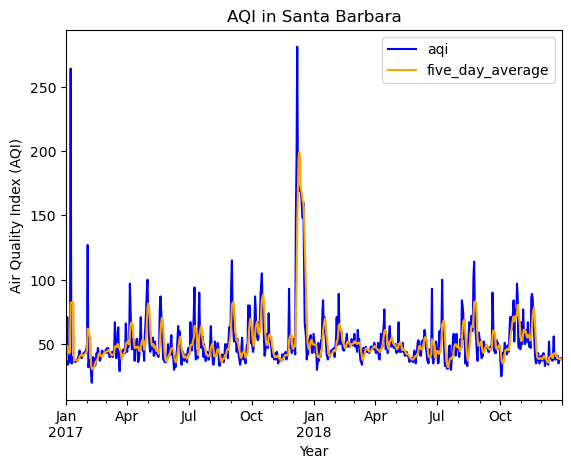

In [21]:
#Plot data
aqi_sb.plot(y = ['aqi', 'five_day_average'], #plot both aqi and five_day_average column
           title = 'AQI in Santa Barbara', #add title to graph
           xlabel = 'Year', #add x label to graph
           ylabel = 'Air Quality Index (AQI)', #add y label to graph
           color = {'aqi': 'blue', #add blue to aqi line
                    'five_day_average': 'orange' #add orange to five_day_average line
                   }
           )

#save plot into image folder
plt.savefig('images/aqi_in_santa_barbara.png', bbox_inches='tight',  dpi=100)

At around December 2017, There is a large spike in the AQI with both the daily and 5 day average. Surprisingly, there in an increase in AQI at January 2017. I assume there was a fire at the beginning of that year.

## Landsat Band Raster

### Geographic context

Let's go ahead and see where the Thomas fire area burned on California:

### Prepare Raster data

### Data Exploration:

Let's go ahead and read in our band raster data to see what it contains

In [11]:
#print bands data
ca_fires_bands_2017

<xarray.Dataset>
Dimensions:      (y: 731, x: 870, band: 1)
Coordinates:
  * y            (y) float64 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
  * x            (x) float64 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * band         (band) int64 1
    spatial_ref  int64 0
Data variables:
    red          (band, y, x) float64 ...
    green        (band, y, x) float64 ...
    blue         (band, y, x) float64 ...
    nir08        (band, y, x) float64 ...
    swir22       (band, y, x) float64 ...

### Squeeze and drop bands

In order to map this out, we need to drop our bands. If the bands are not dropped, our raster will not be graphable as it contains more than 2 axis.

In [12]:
#get rid of band in ca_fires_band_2017
# original dimensions and coordinates
print('original dimensions: ', ca_fires_bands_2017.dims,'\n')

# remove length 1 dimension (band)
ca_fires_bands_2017 = ca_fires_bands_2017.squeeze()
print('removed band from dimensions: ', ca_fires_bands_2017.dims,'\n')

# remove coordinates associated to band
ca_fires_bands_2017 = ca_fires_bands_2017.drop('band')
print('new dimensions: ', ca_fires_bands_2017.dims)

original dimensions:  Frozen({'y': 731, 'x': 870, 'band': 1}) 

removed band from dimensions:  Frozen({'y': 731, 'x': 870}) 

new dimensions:  Frozen({'y': 731, 'x': 870})


### Create a False Color image

Now that our raster file is ready, we want to be able to map it. Mapping a true color image will make it harder to notice the burn area of where the Thomas fire took place, so we will map a False Color image in order to make it visually easier to see where the burned area took place.

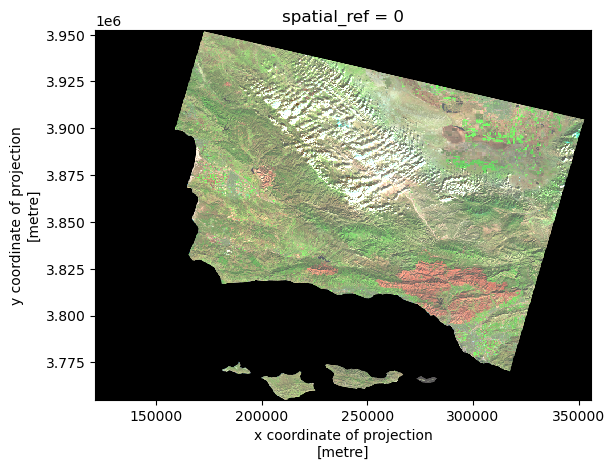

In [13]:
#plot a false color image by plotting the swir22, nir, and red variables
ca_fires_bands_2017[['swir22', 
                     'nir08', 
                     'red']].to_array().plot.imshow(robust = True)

## California Shapefile data

### Prepare Shapefile data

### Data Exploration:

<AxesSubplot:>

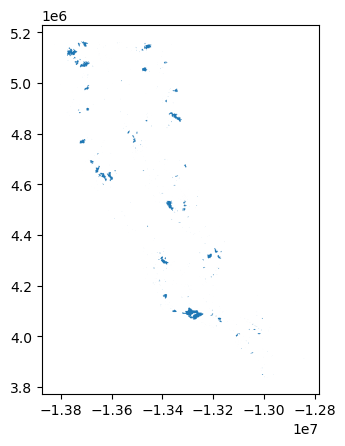

In [14]:
#look at head of fire perimeter
ca_fires_perimeter_2017.head()

#plot data to see what it looks like
ca_fires_perimeter_2017.plot()

### Reformat columns

To make data wrangling easier, we will be changing the column names to make it easier to interact with.

In [15]:
#change column names:
#make columns lower case
ca_fires_perimeter_2017.columns = ca_fires_perimeter_2017.columns.str.lower()
#print columns names to make sure they were changed
ca_fires_perimeter_2017.columns

Index(['index', 'objectid', 'year_', 'state', 'agency', 'unit_id', 'fire_name',
       'inc_num', 'alarm_date', 'cont_date', 'cause', 'c_method', 'objective',
       'gis_acres', 'comments', 'complex_na', 'complex_in', 'irwinid',
       'fire_num', 'decades', 'shape_leng', 'shape_area', 'geometry'],
      dtype='object')

### Change California shapefile CRS

In order to map this perimeter on top of the raster map, we need to make sure the two CRS's are the same in order for the overlap to be exact. We will go ahead and change the CRS in this step:

In [16]:
#change crs
ca_fires_perimeter_2017 = ca_fires_perimeter_2017.to_crs(ca_fires_bands_2017.rio.crs)
#see if they matched after the change
print('matched crs?',  ca_fires_perimeter_2017.crs == ca_fires_bands_2017.rio.crs)

matched crs? True


### Create the Thomas fire Perimeter

The `California_Fire_Perimeters_2017.shp` includes information of all burns that occured in 2017. In our case, we are only interested in the Thomas fire. We will go ahead and filter for the Thomas fire entry.

In [17]:
#create thomas fire perimeter
thomas_perimeter = ca_fires_perimeter_2017[ca_fires_perimeter_2017['fire_name']=='THOMAS']
#print to see if thomas perimeter was captured
thomas_perimeter

,index,objectid,year_,state,agency,unit_id,fire_name,inc_num,alarm_date,cont_date,...,gis_acres,comments,complex_na,complex_in,irwinid,fire_num,decades,shape_leng,shape_area,geometry
436,20274,41874,2017,CA,USF,VNC,THOMAS,00003583,2017-12-04,2018-01-12,...,281790.875,CONT_DATE based on Inciweb,None,None,None,None,2010,540531.887458,1.681106e+09,"MULTIPOLYGON (((259241.263 3814482.913, 259193..."


### Mapping Landsat and Thomas Fire perimeter

After preparing our data for both the Landsat and Thomas Fire, we are ready to map the two, with the Thomas Fire perimeter on top of the Landsat map. This will help highlight where the Thomas Fire took place.

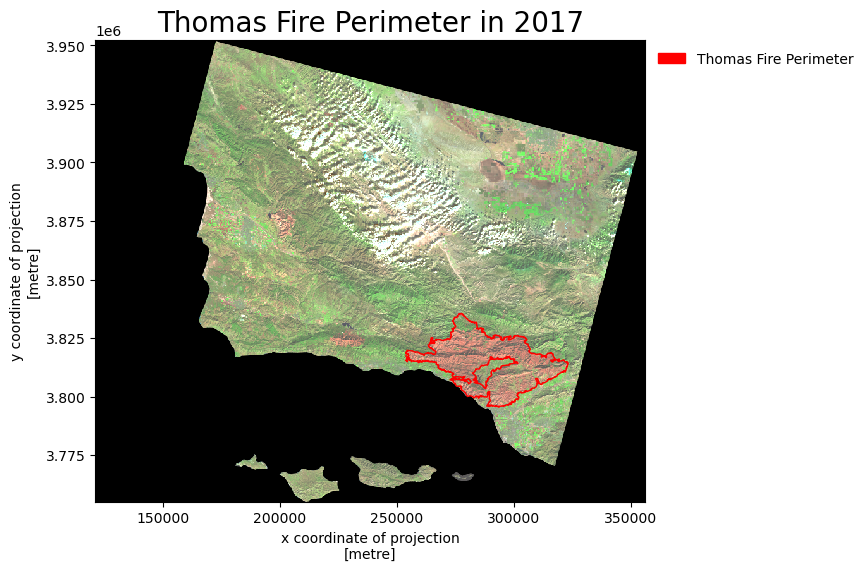

In [24]:
#create map
#plot an empty plot
fig, ax = plt.subplots(figsize = (8,6))


#plot CA fire bands map as the base
ca_fires_bands_2017[['swir22', #subset for the three wanted bands
                     'nir08', 
                     'red']].to_array().plot.imshow(ax = ax,
                                                    robust = True)

#plot thomas fire perimeter over base map
thomas_perimeter.plot(ax = ax, edgecolor = "red", color = 'none') #plot thomas_perimeter
thomas_perimeter_patches = mpatches.Patch( color = "red", #create label for legend and change color
                                    label = "Thomas Fire Perimeter") #set label

#set title for map
ax.set_title('Thomas Fire Perimeter in 2017',
fontsize=20) #change font size

#add legend onto map
ax.legend(handles = [thomas_perimeter_patches], frameon=False, loc='upper left', bbox_to_anchor = (1, 1))

#save plot into image folder
plt.savefig('images/thomas_fire_perimeter_2017.png', bbox_inches='tight',  dpi=100)